In [138]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

indicadores = pd.read_csv("data/indicadores_CEINS.csv")
indicadores = indicadores[['fecha','occ']]

In [139]:
def regresa_ds(data,window=1,dropnan=True):
    for x in range(1,window+1):
        column = 't-'+str(window-x)
        data[column]=data['occ'].shift(window-x)
        
    if dropnan:
        data.dropna(inplace=True)
        
    data=data.drop('occ',1)
    
    return data



In [140]:
lags = 100
indicadores = regresa_ds(indicadores,lags,1)

In [141]:
import datetime
indicadores['fecha']=pd.to_datetime(indicadores['fecha'],format='%Y-%m-%d')
indicadores['dow']=indicadores['fecha'].dt.strftime('%A')
indicadores['year']=indicadores['fecha'].dt.strftime('%Y')
indicadores['month']=indicadores['fecha'].dt.strftime('%m')
indicadores['day']=indicadores['fecha'].dt.strftime('%d')
indicadores['y']=indicadores['t-0']
df_dow = pd.get_dummies(indicadores['dow'])
indicadores = pd.concat([indicadores,df_dow],axis=1)
indicadores=indicadores.drop('dow',1)
indicadores=indicadores.drop('t-0',1)



In [142]:
### Creamos data set de entrenamiento y prueba
train_size = int(len(indicadores)*0.66)
train, test = indicadores[0:train_size], indicadores[train_size:len(indicadores)]


In [143]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
         plt.subplot(models_to_plot[alpha])
         plt.tight_layout()
         plt.plot(data['fecha'],y_pred)
         plt.plot(data['fecha'],data['y'],'.')
         plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret, y_pred

/Users/ocamarena/.pyenv/versions/3.5.2/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.176686378058157e-17 / 1.1102230246251565e-16
  RuntimeWarning)


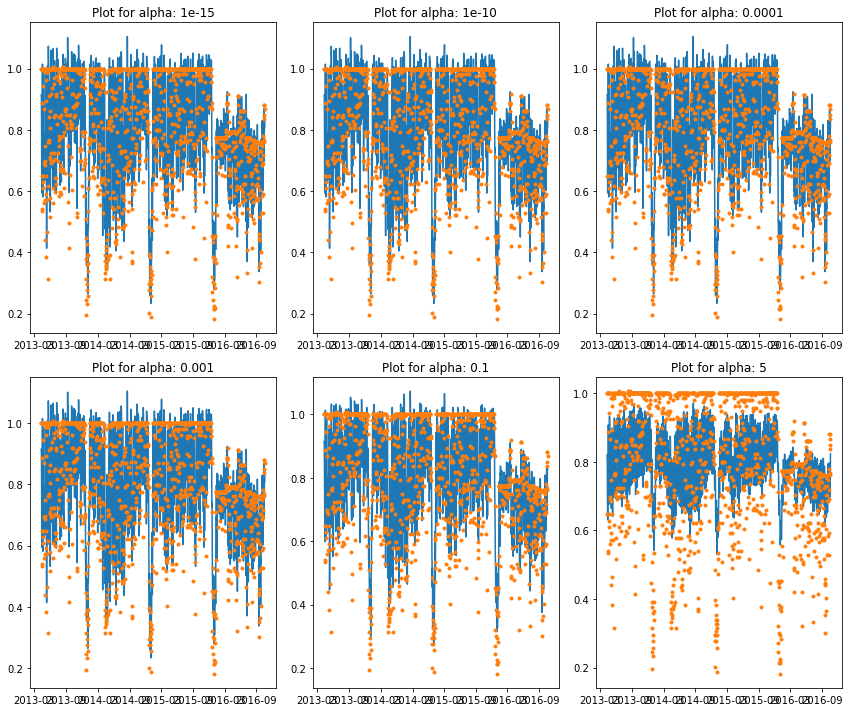

In [144]:
predictors=['t-1']
predictors.extend(['t-%d'%i for i in range(2,lags)])
predictors = predictors + ['year','month','day','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, .1, 5, 10, 20]

col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,len(predictors)+1)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)
y_pred = [None] * 10
models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, .1:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,],y_pred[i] = ridge_regression(train, predictors, alpha_ridge[i], models_to_plot)

In [145]:
print(coef_matrix_ridge)

                  rss intercept   coef_x_1   coef_x_2    coef_x_3    coef_x_4  \
alpha_1e-15   13.0483   9.91188   0.741263  -0.100186   0.0404572   0.0534656   
alpha_1e-10   13.0483   9.91753   0.741263  -0.100186   0.0404572   0.0534656   
alpha_1e-08   13.0483   9.91753   0.741263  -0.100186   0.0404572   0.0534656   
alpha_0.0001  13.0483   9.91972   0.740907 -0.0998408   0.0403287   0.0535294   
alpha_0.001   13.0486   9.93915   0.737739 -0.0967835    0.039207   0.0540794   
alpha_0.01    13.0732   10.1163   0.708897 -0.0702998   0.0307706   0.0577775   
alpha_0.1     13.7429   11.1067   0.542974  0.0426204   0.0215537   0.0578306   
alpha_5       26.1422   6.82676  0.0847522  0.0483549   0.0292367   0.0263691   
alpha_10      30.9543   4.87133  0.0511564  0.0300437   0.0178232   0.0160885   
alpha_20      36.1559   3.30803  0.0293617  0.0172543  0.00976463  0.00879455   

               coef_x_5   coef_x_6   coef_x_7    coef_x_8     ...      \
alpha_1e-15   0.0658741 -0.0208404 

In [146]:
##Escogemos el modelo con alpha igual 1e-15 lo entrenamos nuevamente y lo probamos
alpha = 1e-15
predictors=['t-1']
predictors.extend(['t-%d'%i for i in range(2,lags)])
predictors = predictors + ['year','month','day','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ridgereg = Ridge(alpha=alpha,normalize=True)
ridgereg.fit(train[predictors],train['y'])
y_pred_test = ridgereg.predict(test[predictors])



/Users/ocamarena/.pyenv/versions/3.5.2/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.176686378058157e-17 / 1.1102230246251565e-16
  RuntimeWarning)


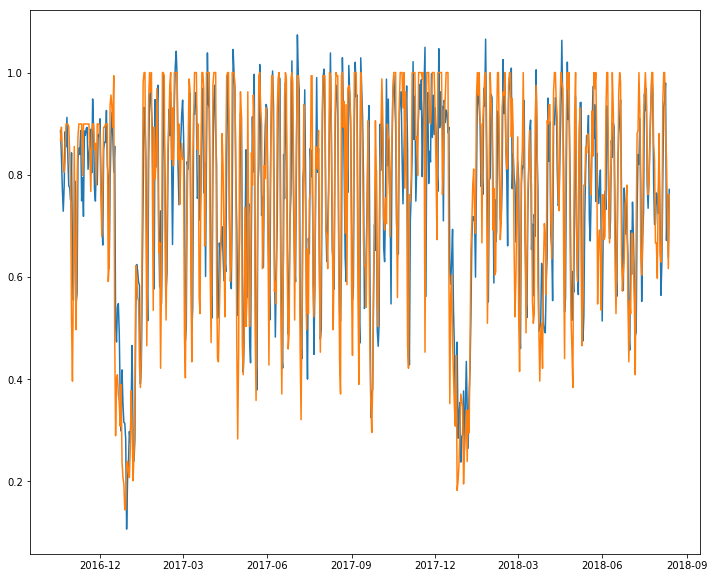

In [147]:
plt.plot(test['fecha'],y_pred_test)
plt.plot(test['fecha'],test['y'])
plt.show()